In [ ]:
!pip install transformers[torch]

# Frozen: Finetuning ClimateBERT for Greenwashing Risk Detection

Generating groundtruth colab: https://colab.research.google.com/drive/1bSpBF9-vLyo7Zh7q_QYV0d_GWGvipZle

Pretrained ClimateBERT Full: https://huggingface.co/climatebert/distilroberta-base-climate-f

Fine tuning tutorial: https://huggingface.co/docs/transformers/training

Layer freezing: https://discuss.huggingface.co/t/freeze-lower-layers-with-auto-classification-model/11386

F1 score?: https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

%cd /content/drive/Shareddrives/CS263-Project/

/content/drive/Shareddrives/CS263-Project


In [ ]:
import torch
torch.manual_seed(9)

In [ ]:
## read a csv file and return a dictionary form
import csv

def read_csv_file(filename):
  data_dict = {}

  with open(filename) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for i, row in enumerate(csv_reader): # row is a list at this point
      if line_count == 0:
        print(f'Column names are {", ".join(row)}')
        line_count += 1
      else:
        text = row[0]
        binary_sentiment = int(row[1])
        specificity = int(row[2])
        commitment = int(row[3])
        deflection = int(row[4]) # new line
        label = int(row[5])
        data_dict[i] = {
            "text": text,
            "binary_sentiment": binary_sentiment,
            "specificity": specificity,
            "commitment": commitment,
            "deflection": deflection,
            "label": label
        }

    return data_dict

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
train_dataset = load_dataset('csv', data_files=['data/FINAL-train-data.csv'])
val_dataset = load_dataset('csv', data_files=['data/FINAL-val-data.csv'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
val_dataset

In [ ]:
train_dataset

In [ ]:
!pip install transformers

In [ ]:
# create tokenizer and tokenizer function

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("climatebert/distilroberta-base-climate-f")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# create tokenized train and test maps

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1056 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

In [ ]:
# import pretrained climate bert (f)ull model

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("climatebert/distilroberta-base-climate-f", num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50500, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [ ]:
# freeze layer roberta
"""for name, param in model.named_parameters():
  print(str(name))
  if name.startswith("roberta"): # choose whatever you like here
    param.requires_grad = False"""

'for name, param in model.named_parameters():\n  print(str(name))\n  if name.startswith("roberta"): # choose whatever you like here\n    param.requires_grad = False'

In [ ]:
tokenized_train = tokenized_train.remove_columns(['text', 'binary_sentiment', 'specificity', 'commitment', 'hedging'])
tokenized_val = tokenized_val.remove_columns(['text', 'binary_sentiment', 'specificity', 'commitment', 'hedging'])
#tokenized_test = tokenized_test.remove_columns(['number', 'text', 'sentiment', 'binary_sentiment', 'tcfd', 'climate_specificity', 'commitment', 'deflection', 'detection'])

In [ ]:
# keep the label column, rename to "labels" for forward pass
#tokenized_train = tokenized_train.rename_column("greenwashing_risk", "labels")
#tokenized_val = tokenized_val.rename_column("greenwashing_risk", "labels")
#tokenized_test = tokenized_test.rename_column("greenwashing_risk", "labels")

In [ ]:
# set format to torch
tokenized_train.set_format("torch")
tokenized_val.set_format("torch")
#tokenized_test.set_format("torch")

### NOTE: See comment in the cell below!

In [ ]:
# try to use gpu

import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50500, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

## NOTE: Rebecca is going to define these as functions so that we can print the validation accuracy after each epoch!


In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.6 MB/s eta 0:00:00


### NOTE: For now, while we're still doing experiments, I will only report on the validation accuracy, but we should eventually change this to the test accuracy.

In [ ]:
!pip install transformers[torch]

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
pip install transformers[torch]

In [ ]:
pip install accelerate -U

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer",
                                  num_train_epochs=70,
                                  evaluation_strategy="epoch")

In [ ]:
tokenized_val

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 264
    })
})

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train['train'],
    eval_dataset=tokenized_val['train'],
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()
trainer.save_model("/content/drive/Shareddrives/CS263-Project/final-models/unfrozen-no-interc/unfrozen-9")

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.679183,0.689394
2,No log,0.837270,0.678030
3,No log,1.224123,0.674242
4,0.338800,1.475940,0.753788
5,0.338800,2.101737,0.696970
6,0.338800,1.749922,0.734848
7,0.338800,2.410624,0.704545
8,0.040400,2.599072,0.704545
9,0.040400,2.590073,0.693182
10,0.040400,2.715945,0.712121


In [ ]:
predictions = trainer.predict(tokenized_val['train'])
preds = np.argmax(predictions.predictions, axis=-1)
metric = evaluate.load("f1")
metric.compute(predictions=preds, references=predictions.label_ids)

{'f1': 0.6896551724137931}

## Evaluation

NameError: ignored

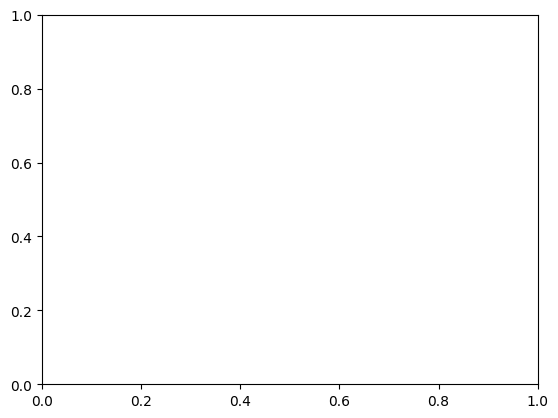

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots()

# Plot training losses
ax.plot(losses, label='Training Loss')

# Plot val loss
ax.plot(val_losses, label='Val Loss')

# Plot training accuracies
# ax.plot(accuracies, label='Accuracies')

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss, Frozen Training')

# Display the legend
ax.legend()

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots()

# Plot training accuracies
ax.plot(accuracies, label='Accuracies')

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy')

# Display the legend
ax.legend()

# Show the plot
plt.show()

In [ ]:
# # final test accuracy

# test_loss, test_accuracy = test(model, test_dataloader)
# print(f"Final test accuracy: {final_test_accuracy:.4f}")

## AUCROC for the Val and Test Sets
https://huggingface.co/spaces/evaluate-metric/roc_auc

THIS ONE: https://medium.com/analytics-vidhya/easily-implement-different-transformers-through-hugging-face-e471035e9c86

In [ ]:
from sklearn.metrics import roc_curve,confusion_matrix,auc
import numpy as np
import pandas as pd
import seaborn as sns


def plot_cm(y_true, y_pred, title):
    ''''
    input y_true-Ground Truth Labels
          y_pred-Predicted Value of Model
          title-What Title to give to the confusion matrix

    Draws a Confusion Matrix for better understanding of how the model is working

    return None

    '''

    figsize=(10,10)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic on validation')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
roc_auc_score = evaluate.load("roc_auc")
refs = [1, 0, 1, 1, 0, 0]
pred_scores = [0.5, 0.2, 0.99, 0.3, 0.1, 0.7]
results = roc_auc_score.compute(references=refs, prediction_scores=pred_scores)
print(round(results['roc_auc'], 2))

In [ ]:
def get_probs(model, train_dataloader, dataset=None):
  # predict and get the accuracy
  logits = []
  total = 0
  for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      logit = model(**batch).logits
      logit = torch.nn.functional.softmax(logit)
      logits.append(logit)
    total += 1

  #print(logits)
  for i in range(1, len(logits)):
    logits[0] = torch.cat((logits[0], logits[i]))
  return logits, total

In [ ]:
# FIX THIS TO WORK FOR OUR VALIDATION SET
y_predict, total = get_probs(model, eval_dataloader)

In [ ]:
print(val_dataset['train']['greenwashing_risk'])

In [ ]:
y_preds = []
for probs in y_predict[0]:
  pos_prob = probs[-1]
  if pos_prob > 0.5:
    y_preds.append(1)
  else:
    y_preds.append(0)

assert(len(y_preds) == len(val_dataset['train']['greenwashing_risk']))
plot_cm(val_dataset['train']['greenwashing_risk'], y_preds, 'Fine-Tuned ClimateBERT Val Performance-Confusion Matrix')

In [ ]:
# FIX THIS TO WORK FOR OUR VALIDATION SET
y_predict_prob = []
for probs in y_predict[0]:
  pos_prob = probs[-1].item()
  print(pos_prob)
  y_predict_prob.append(pos_prob)
print(np.array(val_dataset['train']['greenwashing_risk']))
print(y_predict_prob)
print(np.array(y_predict_prob))
fpr, tpr, _ = roc_curve(np.array(val_dataset['train']['greenwashing_risk']), np.array(y_predict_prob))
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc)

In [ ]:
roc_curve(np.array([1, 1, 0, 1]), np.array([0.5, 0.4, 0.3, 0.1]))

In [ ]:
# Check false predictions
from pprint import pprint

# stats
false = 0
pos = 0
neg = 0
# [false positives, false negatives]
defl = [0,0]
sent = [0,0]
comm = [0,0]
spec = [0,0]

for i, y in enumerate(val_dataset['train']):
  if y_preds[i] != y['greenwashing_risk']:
    false += 1
    if y_preds[i] == 1:
      pos += 1
      if y['deflection'] == 1:
        defl[0] += 1
      if y['binary_sentiment'] == 1:
        sent[0] += 1
      if y['commitment'] == 1:
        comm[0] += 1
      if y['climate_specificity'] == 1:
        spec[0] += 1
      pprint(y)
    else:
      neg += 1
      if y['deflection'] == 1:
        defl[1] += 1
      if y['binary_sentiment'] == 1:
        sent[1] += 1
      if y['commitment'] == 1:
        comm[1] += 1
      if y['climate_specificity'] == 1:
        spec[1] += 1
    # pprint(y)

In [ ]:
print("Number of false predictions: %d\nWith deflection: %d (%.3f)\nWith positive sentiment: %d (%.3f)\nWith commitment: %d (%.3f)\nWith specificity: %d (%.3f)\n" % (false, sum(defl), sum(defl)/false, sum(sent), sum(sent)/false, sum(comm), sum(comm)/false, sum(spec), sum(spec)/false))
print("Number of false positives: %d\nWith deflection: %d (%.3f)\nWith positive sentiment: %d (%.3f)\nWith commitment: %d (%.3f)\nWith specificity: %d (%.3f)\n" % (pos, defl[0], defl[0]/pos, sent[0], sent[0]/pos, comm[0], comm[0]/pos, spec[0], spec[0]/pos))
print("Number of false negatives: %d\nWith deflection: %d (%.3f)\nWith positive sentiment: %d (%.3f)\nWith commitment: %d (%.3f)\nWith specificity: %d (%.3f)\n" % (neg, defl[1], defl[1]/neg, sent[1], sent[1]/neg, comm[1], comm[1]/neg, spec[1], spec[1]/neg))

In [ ]:
# for reference, the total % of data points that contain deflection, commitment, etc
defl_tot = sum(train_dataset['train']['deflection']) + sum(val_dataset['train']['deflection'])
sent_tot = sum(train_dataset['train']['binary_sentiment']) + sum(val_dataset['train']['binary_sentiment'])
comm_tot = sum(train_dataset['train']['commitment']) + sum(val_dataset['train']['commitment'])
spec_tot = sum(train_dataset['train']['climate_specificity']) + sum(val_dataset['train']['climate_specificity'])
tot = len(train_dataset['train']) + len(val_dataset['train'])
print("Deflection: %.3f\nSentiment: %.3f\nCommitment: %.3f\nSpecificity: %.3f" % (defl_tot/tot, sent_tot/tot, comm_tot/tot, spec_tot/tot))

## Test Set ROC

## Test Set

In [ ]:
def calculate_f1(preds, true):
  TP, FP, FN = 0.0, 0.0, 0.0
  for i in range(len(preds)):
    if preds[i] == 1:
      if true[i] == 1:
        TP += 1
      else:
        FP += 1
    else:
      if true[i] == 1:
        FN += 1

  recall = TP / (TP + FN)
  prec = TP / (TP + FP)

  F1 = 2 / ((1/recall) + (1/prec))
  return F1

In [ ]:
def predict_csv_labels(file_name, tokenizer, model):
  # load the dataset
  #print(model)
  dataset = load_dataset('csv', data_files=['data/' + file_name + '.csv'])
  print(dataset)

  # predict and get the accuracy
  correct, total = 0, 0
  preds = []
  for index, example in enumerate(dataset['train']):
    #print(example)
    input = tokenizer(example['text'], return_tensors="pt")
    input = input.to(device)
    #print(input)
    with torch.no_grad():
      #print(input['input_ids'])
      logits = model(**input).logits
    pred = torch.argmax(logits, dim=-1)
    preds.append(pred)
    if pred == dataset['train']['greenwashing_risk'][index]:
      correct += 1
    total += 1

  # accuracy
  report_acc = correct / total
  # F1
  report_f1 = calculate_f1(preds, dataset['train']['greenwashing_risk'])

  overall_pred = 0
  majority = sum(preds) / len(preds)
  if majority > 0.5:
    overall_pred = 1

  overall_true = 0
  true_maj = sum(dataset['train']['greenwashing_risk']) / len(dataset['train']['greenwashing_risk'])
  if true_maj > 0.5:
    overall_true = 1

  return overall_pred, overall_true, report_acc, report_f1

In [ ]:
file_list = ['Diamondback_2021-final', 'Devon_2021-final', 'APA_2021-final', 'Autodesk_2021-final', 'ServiceNow_2021-final', 'NVIDIA_2021-final']

In [ ]:
!ls

'263 project meeting notes.gdoc'      frozen-model2
'263 Project Proposal.gdoc'	      models
'263 Project reading notes.gdoc'      paper-presentation
 code				      readings
'CS263 Final Project Proposal.gdoc'   submittables
 data				      test_trainer
'equation experiments.gsheet'	      tmp_trainer
'experiment logs.gdoc'		     'Untitled spreadsheet.gsheet'
 final-models			      writing
 frozen-model1


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/Shareddrives/CS263-Project/final-models/unfrozen-no-interc/unfrozen-4")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50500, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [ ]:
for file_name in file_list:
  overall_label, overall_true, report_acc, report_f1 = predict_csv_labels(file_name, tokenizer, model)
  print("Predicted Label: " + str(overall_label))
  print("Actual Label: " + str(overall_true))
  print("Report's Accuracy: " + str(report_acc))
  print("Report's F1 Score: " + str(report_f1))
  print()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['number', 'text', 'sentiment', 'binary_sentiment', 'tcfd', 'climate_specificity', 'commitment', 'detection', 'greenwashing_risk'],
        num_rows: 57
    })
})
Predicted Label: 0
Actual Label: 0
Report's Accuracy: 0.8245614035087719
Report's F1 Score: 0.6666666666666666



Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['number', 'text', 'sentiment', 'binary_sentiment', 'tcfd', 'climate_specificity', 'commitment', 'detection', 'greenwashing_risk'],
        num_rows: 90
    })
})
Predicted Label: 0
Actual Label: 0
Report's Accuracy: 0.8333333333333334
Report's F1 Score: 0.6341463414634146



Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['number', 'text', 'sentiment', 'binary_sentiment', 'tcfd', 'climate_specificity', 'commitment', 'detection', 'greenwashing_risk'],
        num_rows: 74
    })
})
Predicted Label: 0
Actual Label: 0
Report's Accuracy: 0.8513513513513513
Report's F1 Score: 0.7441860465116279



Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['number', 'text', 'sentiment', 'binary_sentiment', 'tcfd', 'climate_specificity', 'commitment', 'detection', 'greenwashing_risk'],
        num_rows: 57
    })
})
Predicted Label: 0
Actual Label: 0
Report's Accuracy: 0.8596491228070176
Report's F1 Score: 0.5555555555555556



Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['number', 'text', 'sentiment', 'binary_sentiment', 'tcfd', 'climate_specificity', 'commitment', 'detection', 'greenwashing_risk'],
        num_rows: 19
    })
})
Predicted Label: 0
Actual Label: 0
Report's Accuracy: 0.8947368421052632
Report's F1 Score: 0.6666666666666666



Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['number', 'text', 'sentiment', 'binary_sentiment', 'tcfd', 'climate_specificity', 'commitment', 'detection', 'greenwashing_risk'],
        num_rows: 36
    })
})
Predicted Label: 0
Actual Label: 0
Report's Accuracy: 0.9166666666666666
Report's F1 Score: 0.7272727272727273



## Plot validation set evaluation


In [ ]:
from statistics import stdev, mean

frozen_acc = [67.8, 67.66, 68.18, 68.35, 67.42, 67.8, 68.66, 63.23, 63.02, 63.03]
frozen_f1 = [0.684, 0.6766, 0.6912, 0.6889, 0.6791, 0.684, 0.6818, 0.6863, 0.6889, 0.6815]

print(mean(frozen_acc), stdev(frozen_acc))
print(mean(frozen_f1), stdev(frozen_f1))

66.515 2.388036152713493
0.68423 0.004648548160447516


In [ ]:
from statistics import stdev, mean

unfrozen_acc = [68.0, 71.21, 73.48, 69.7, 73.65, 72.99, 70.80, 70.08, 68.56, 69.32]
unfrozen_f1 = [0.66, 0.7246, 0.6973, 0.6947, 0.7235, 0.7197, 0.697, 0.7127, 0.6667, 0.6897]

print(mean(unfrozen_acc), stdev(unfrozen_acc))
print(mean(unfrozen_f1), stdev(unfrozen_f1))

70.779 2.0287130567595484
0.69859 0.02247534204411582


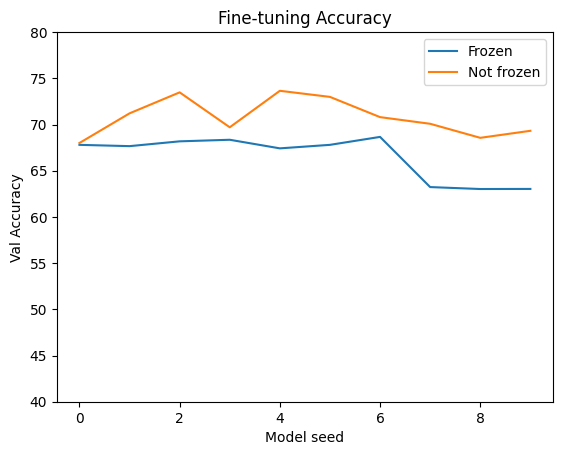

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots()

# Plot training losses
ax.plot(range(10), frozen_acc, label='Frozen')

# Plot val loss
ax.plot(range(10), unfrozen_acc, label='Not frozen')

# Plot training accuracies
# ax.plot(accuracies, label='Accuracies')

# Set labels and title
ax.set_xlabel('Model seed')
ax.set_ylabel('Val Accuracy')
ax.set_title('Fine-tuning Accuracy')
plt.ylim(40, 80)

# Display the legend
ax.legend()

# Show the plot
plt.show()

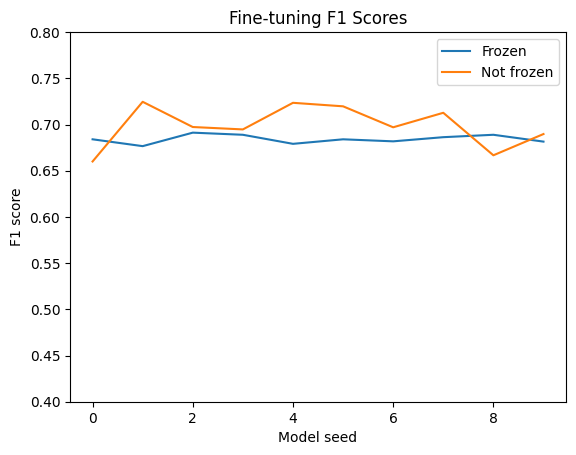

In [ ]:
fig, ax = plt.subplots()
# Plot training losses
ax.plot(range(10), frozen_f1, label='Frozen')

# Plot val loss
ax.plot(range(10), unfrozen_f1, label='Not frozen')

# Plot training accuracies
# ax.plot(accuracies, label='Accuracies')

# Set labels and title
ax.set_xlabel('Model seed')
ax.set_ylabel('F1 score')
ax.set_title('Fine-tuning F1 Scores')
plt.ylim(0.4, 0.8)

# Display the legend
ax.legend()

# Show the plot
plt.show()